<a href="https://colab.research.google.com/github/danjohnvelasco/AI-Sandbox/blob/master/Logistic_Regression_(from_scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

A one layer neural network for binary classification of images (Cat or Not Cat?)

## Steps
1. Get Data
2. Preprocess Data
3. Forward Pass
4. Backward Pass
5. Optimizer (Gradient Descent)
6. Training Func
7. Predict Func
8. Plot losses
9. Refactor

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

## Get Data

In [ ]:
!gdown --id 1Fl58wAcIPtGt5-3MzOr0zvXZDL-3WRQi
!mkdir datasets
!unzip catvnoncat.zip -d datasets

In [39]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [40]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


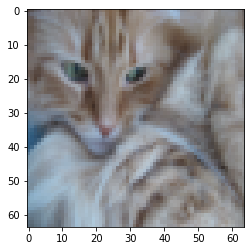

In [41]:
# Example of a picture
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [42]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


## Preprocess Data

In [43]:
def tfms_flatten(X):
    '''
    Returns a flattened (row vector) image.
    Transforms n-dimensional numpy array into a row vector (n, n_instances)

    Inputs:
    - X: An n-dimensional numpy array

    Returns:
    - A numpy array of shape (n, n_instances). Where n_instances is the number of
      images in a dataset and n is the number of dimensions.
    '''
    return np.reshape(X, (X.shape[0], -1)).T

def standardize_img(X):
    '''
    Returns the standardized version of the input.

    Rescales the image data by from 0-255 to 0-1 dividing each element of X
    by max pixel value (255).

    Inputs:
    - X: An n-dimensional numpy array

    Returns:
    - A standardized image data
    '''
    return X/255

In [44]:
# Flatten image
X_train_flatten = tfms_flatten(train_set_x_orig)
X_test_flatten = tfms_flatten(test_set_x_orig)

# Tests
# ensures that the data is a subset
assert(X_train_flatten.shape == (12288, 209))
assert(X_test_flatten.shape == (12288, 50))


print(X_train_flatten.shape, X_test_flatten.shape)

(12288, 209) (12288, 50)


In [45]:
# Standardize
X_train = standardize_img(X_train_flatten)
X_test = standardize_img(X_test_flatten)

print(X_train.shape, X_test.shape)

(12288, 209) (12288, 50)


## Forward Pass and Backward Pass

In [46]:
def zero_init(n_dim):
    '''
    Returns an ndarray of size (n_dim, 1) and a scalar.

    Initialize weights and bias term.

    Input:
    - n_dim : int
        Number of dimensions
    Returns:
    - w : ndarray
        An ndarray of zeroes
    - b : ndarray
        A zero scalar
    '''
    w = np.zeros((n_dim, 1))
    b = 0

    return w, b

In [47]:
def random_init(n_dim):
    '''
    Returns an ndarray of size (n_dim, 1) with random values 
    and a scalar of random value.

    Initialize weights and bias with random values.

    Input:
    - n_dim : int
        Number of dimensions

    Returns:
    - w : ndarray
        An ndarray of random values
    - b : ndarray
        A scalar with random value
    '''
    w = np.random.rand(n_dim,1)
    b = np.random.rand(1,)[0] # scalar

    return w, b

In [48]:
def sigmoid(z):
    '''
    Returns an ndarray with the sigmoids of the input.
    '''
    return 1/(1+np.exp(-1*z))

In [63]:
def loss(y, y_pred):
    y = y.reshape(1, y.shape[1]) # ensure shape (1, y_instances)
    y_1 =  y * np.log(y_pred) # if y == 1
    y_0 = (1-y) * np.log(1 - y_pred) # if y == 0
    cost = np.sum(y_1 + y_0)/(-1 * y_pred.shape[1])
    return cost

In [64]:
def forward_backward_pass(w, b, X, y):
    '''
    Returns weights, biases, and respective gradients with respect to 
    some loss function.

    Forward pass: calculates sigmoid(z) to get predictions and get cost
    Backward pass: calculate gradients of w and b with respect to cost

    Inputs:
    - w : ndarray
        weights of size (n, 1) where n is the number of dimensions
    - b : scalar
        bias term
    - X: ndarray (3072, n)
        Training data
    - y: ndarray (1, n)
        Training labels
    
    Returns: (ARE YOU SURE?)
    - grads : dict
        A dictionary of gradients
    - cost: numpy.float64
        A float that represents the overall cost over the whole training data
    '''
    # Forward Pass
    # Layer 1
    i_h = np.dot(w.T, X) + b # input to hidden (1, n)
    # Activation
    h_o = sigmoid(i_h) # hidden to output (1, n)


    # Loss
    cost = loss(y, h_o)

    # Backward Pass
    m = X.shape[1] # n
    dw = (np.dot(X, (h_o - y).T))/m
    db = np.sum((h_o - y)/m).reshape(1,1)
    
    # Tests
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}


    return grads, cost

### Test

In [65]:
# Initialize parameters
n_dim = X_train.shape[0]
w, b = zero_init(n_dim)

# Tests
assert(w.shape == (12288, 1))
assert(np.isscalar(b))

In [87]:
# Batch Gradient Descent
# Uses the whole dataset to take 1 step of gradient descent

grads1 = {}
cost = 0

# Initialize parameters
n_dim = X_train.shape[0] 
w, b = zero_init(n_dim)

# Set hyperparemeter
learning_rate = 0.005
num_iterations = 1

for i in range(num_iterations):
    grads1, cost = forward_backward_pass(w, b, X_train, train_set_y)

    w = w - learning_rate * grads["dw"]
    b = b - learning_rate * grads["db"]

    if i % 10 == 0:
        print(f"Iteration {i+1}: {cost}")
        print(w)
        print(b)

Iteration 1: 0.6931471805599453
[[-0.00023604]
 [-0.00031499]
 [-0.00024618]
 ...
 [-0.00025373]
 [-0.00031063]
 [-0.00016226]]
[[-0.00077751]]


In [110]:
grads1

{'db': array([[0.15550239]]), 'dw': array([[0.04720893],
        [0.06299841],
        [0.04923539],
        ...,
        [0.05074585],
        [0.0621259 ],
        [0.03245145]])}

## Optimizer

In [162]:
def optimizer(w, b, X, Y, n_iter=10, lr=5e-3):

    # Track loss values
    costs = []

    params = {"w": w,
              "b": b}

    for i in range(n_iter):
        
        grads, cost = forward_backward_pass(w, b, X, Y)

        params["w"] -= learning_rate * grads["dw"]
        params["b"] -= learning_rate * grads["db"]

        # Store loss
        costs.append(cost)

        if i % 100 == 0:
            print(f"Iteration {i+1} - Cost: {cost}")

    return params, grads, costs

### Test

In [115]:
# Initialize parameters
n_dim = X_train.shape[0]
w, b = zero_init(n_dim)

# Tests
assert(w.shape == (12288, 1))
assert(np.isscalar(b))

In [124]:
params, grads, costs = optimizer(w, b, X_train, train_set_y, n_iter=1, lr=5e-3)
grads

Iteration 1 - Cost: 0.7339212123507648


{'db': array([[0.25337312]]), 'dw': array([[0.09488986],
        [0.11009616],
        [0.09409703],
        ...,
        [0.0920804 ],
        [0.10202084],
        [0.06855663]])}

In [125]:
costs

[0.7339212123507648]

# Predict

In [132]:
def predict(w, b, X):
    y_pred = np.zeros((1, X.shape[1]))

    # Forward Pass
    # Layer 1
    i_h = np.dot(w.T, X) + b # input to hidden (1, n)
    # Activation
    h_o = sigmoid(i_h) # hidden to output (1, n)

    # Loop over each item in dataset (columns-wise)
    # Convert probabilities to labels using thresholds
    for i in range(X.shape[1]):
        if (h_o[0,i] > 0.5):
            y_pred[0,i] = 1
        else:
            y_pred[0,i] = 0
        
    return y_pred

# Refactor, combine everything in one Model class

In [158]:
def model(X_train, Y_train, X_test, Y_test, n_iter=1, lr=5e-3, verbose=False):
    # Initialize parameters
    n_dim = X_train.shape[0]
    w, b = zero_init(n_dim)

    # Propagate
    params, grads, costs = optimizer(w, b, X_train, Y_train, n_iter, lr)

    # Retrieve parameters w and b from dictionary "parameters"
    w = params["w"]
    b = params["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    res = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    print(grads)

    return res

In [156]:
res = model(X_train, train_set_y, X_test, test_set_y, n_iter = 1, lr = 5e-3)

Iteration 1 - Cost: 0.6931471805599453
[0.6931471805599453]
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %
{'dw': array([[0.04720893],
       [0.06299841],
       [0.04923539],
       ...,
       [0.05074585],
       [0.0621259 ],
       [0.03245145]]), 'db': array([[0.15550239]])}


You should see

```
Iteration 1 - Cost: 0.693147
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %
{'dw': array([[ 0.04720893],
       [ 0.06299841],
       [ 0.04923539],
       ..., 
       [ 0.05074585],
       [ 0.0621259 ],
       [ 0.03245145]]), 'db': array([[ 0.15550239]])}
```



In [163]:
res = model(X_train, train_set_y, X_test, test_set_y, n_iter = 2000, lr = 5e-3)

Iteration 1 - Cost: 0.6931471805599453
Iteration 101 - Cost: 0.5842388869739894
Iteration 201 - Cost: 0.46664985220250477
Iteration 301 - Cost: 0.37581634839843925
Iteration 401 - Cost: 0.3314999137598888
Iteration 501 - Cost: 0.30329811755127145
Iteration 601 - Cost: 0.2798953587235796
Iteration 701 - Cost: 0.2600507785062307
Iteration 801 - Cost: 0.24294396229917983
Iteration 901 - Cost: 0.2280035410504074
Iteration 1001 - Cost: 0.2148159700690285
Iteration 1101 - Cost: 0.20307263065942507
Iteration 1201 - Cost: 0.19253734679265141
Iteration 1301 - Cost: 0.18302552540337033
Iteration 1401 - Cost: 0.17439026496110832
Iteration 1501 - Cost: 0.1665128209607002
Iteration 1601 - Cost: 0.15929589257613744
Iteration 1701 - Cost: 0.15265879055710246
Iteration 1801 - Cost: 0.146533891303757
Iteration 1901 - Cost: 0.140863989382991
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %
{'dw': array([[-0.00037858],
       [ 0.00126733],
       [ 0.000577  ],
       ...,
       [ 0.0004089 ],

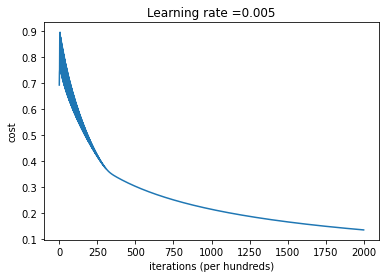

In [164]:
# Plot learning curve (with costs)
costs = np.squeeze(res['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(res["learning_rate"]))
plt.show()